**Rotten Tomatoes Reviews: Archive of more than 480,000 critic reviews (fresh or rotten)**

In [1]:
#import necessary libraries
import tensorflow
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [2]:
print(tensorflow.__version__)

2.5.0


In [8]:
#Read the data in the csv file using read.csv command from Pandas
data = pd.read_csv('reviews.csv',encoding= 'unicode_escape')


**Exploratory Data Analysis**

In [9]:
#info() function is used to get a concise summary of the dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


In [10]:
#we are checking how our dataset looks like by picking first 5 rows using head()
data.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [11]:
#getting the total size of the data 
print(data.size)
print(data[ data['Freshness'] == 'fresh'].size)
print(data[ data['Freshness'] == 'rotten'].size)

960000
480000
480000


In [12]:
#print the no. of Positive and Neagative sentiment tweets.
print("Number of Fresh reviews in the dataset:",len(data[ data['Freshness'] == 'fresh']))
print("Number of rotten reviews in the dataset:",len(data[ data['Freshness'] == 'rotten']))

Number of Fresh reviews in the dataset: 240000
Number of rotten reviews in the dataset: 240000


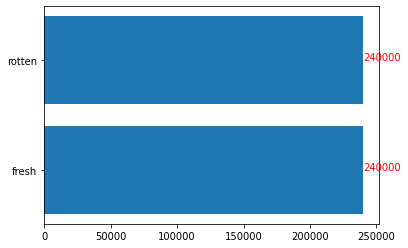

In [13]:
#Using matplotlib,we are visualizing how balanced our dataset is.. 
import matplotlib.pyplot as plt

x = ["fresh", "rotten"]
y = [len(data[data['Freshness'] == 'fresh' ]),len(data[data['Freshness'] == 'rotten' ])]
plt.barh(x, y)

for index, value in enumerate(y):
  plt.text(value, index, str(value),color='red')

Here our dataset is not balanced at all with Positive sentiments being approximately four times larger than negative sentiments.

**Data pre-processing**

In [14]:
#we are checking for null values in all the columns
data.isnull().sum()

Freshness    0
Review       0
dtype: int64

In [15]:
#remove urls from the tweets .Refered from https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/49257661
#checked in https://regexr.com/ -- we tried various combinations and finally took the help of stackoverflow for regex to remove urls

data['Review']  = data['Review'].apply((lambda x:re.sub(r'''(?i)\b((?:(https|http)?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)))

#Tried the below format too,but there are few http urls left out..
#re.sub(r'^(https|http)?:\/\/.*[\r\n]*', '', x)))
#(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*

data.head(4)

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...


In [16]:
#Below are the data cleaning operations for which we have downloaded important libraries from nltk

import string
import nltk
nltk.download(['punkt','stopwords','wordnet'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
text=list()
lines=data['Review'].values.tolist()

for line in lines:
    tokens=word_tokenize(line)
    #convert entire text data to lowercase
    tokens=[w.lower() for w in tokens]
    #remove the punctuations from each word
    table =str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    words=[word for word in stripped if word.isalpha()]
    #filter out stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    text.append(words)
print("\n\n")    
print("Total no.of cleaned rows converted to list: ",len(text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.



Total no.of cleaned rows converted to list:  480000


In [17]:
#checking couple of rows from text to understand how our cleaning data looks like.
text[0:2]

[['manakamana',
  'nt',
  'answer',
  'questions',
  'yet',
  'makes',
  'point',
  'nepal',
  'like',
  'rest',
  'planet',
  'picturesque',
  'far',
  'peaceable',
  'kingdom'],
 ['wilfully',
  'offensive',
  'powered',
  'chestthumping',
  'machismo',
  'good',
  'clean',
  'fun']]

From gazing above two rows from the text,we can see how each row looks like after removing all the punctuations, urls,stopwords ,non alphabetic characters and converting the entire text to lower case for furthur tokenizing and padding pre-processing steps given below.

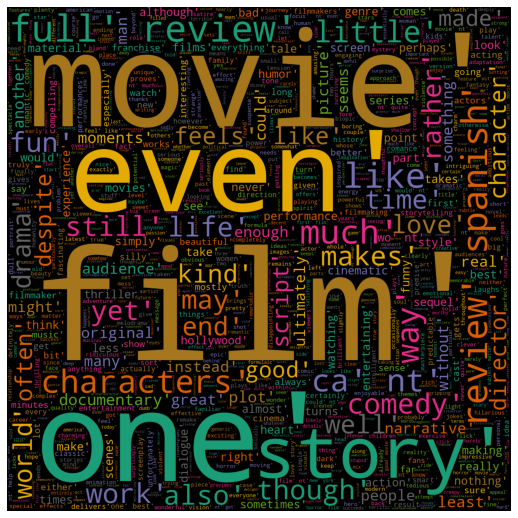

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 1500, height = 1500,background_color ='black',colormap='Dark2',
                      min_font_size = 10, max_words=10729).generate(str(text))


# plot the WordCloud image                    
fig=plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**Tokenization and Padding**

In [19]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(text)
X = tokenizer.texts_to_sequences(text)
#pad_sequences() function transforms tokenized X of sequences (lists of integers) into a 2D Numpy array of shape (num_samples=10729, num_timesteps). 
#num_timesteps is either the maxlen argument if provided, or here in this example, the length of the longest sequence in the list.
X = pad_sequences(X)
print(X)
print("\n")
print(X.shape)


[[   0    0    0 ...  503 1516   80]
 [   0    0    0 ... 1517    9   35]
 [   0    0    0 ...  370  262  356]
 ...
 [   0    0    0 ...  793 1184  268]
 [   0    0    0 ...   65  250    1]
 [   0    0    0 ...  435  365  739]]


(480000, 26)


In [20]:
word_index = tokenizer.word_index
print("We have %s unique tokens. " % len(word_index))

We have 116210 unique tokens. 


**Applying LSTM**

In [21]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1])) #word embedding
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 26, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


**Splitting the pre-processed data to train and test for fitting our model**

In [22]:
#Here, after many tweaks, finally choosing 25% test data and remaining 75% of data to train the model,gave best accuracy.
Y = pd.get_dummies(data['Freshness']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(360000, 26) (360000, 2)
(120000, 26) (120000, 2)


**Fitting the model with epochs=7,batch size=32**

In [23]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
11250/11250 - 1322s - loss: 0.5157 - accuracy: 0.7410
Epoch 2/7
11250/11250 - 1320s - loss: 0.4866 - accuracy: 0.7612
Epoch 3/7
11250/11250 - 1338s - loss: 0.4718 - accuracy: 0.7707
Epoch 4/7
11250/11250 - 1351s - loss: 0.4606 - accuracy: 0.7770
Epoch 5/7
11250/11250 - 1339s - loss: 0.4509 - accuracy: 0.7833
Epoch 6/7
11250/11250 - 1341s - loss: 0.4431 - accuracy: 0.7887
Epoch 7/7
11250/11250 - 1342s - loss: 0.4368 - accuracy: 0.7924


In [24]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("\n")
print("score: %.2f" % (score))
print("Accuracy: %.2f" % (acc))

3704/3704 - 60s - loss: 0.4616 - accuracy: 0.7799


score: 0.46
Accuracy: 0.78


In [25]:
X_validate

array([[   0,    0,    0, ...,  632, 1746, 1871],
       [   0,    0,    0, ...,  303,    7, 1399],
       [   0,    0,    0, ...,   30, 1648,  601],
       ...,
       [   0,    0,    0, ...,  135,  135, 1158],
       [   0,    0,    0, ...,   13,   27,   51],
       [   0,    0,    0, ...,    0,    0,    9]], dtype=int32)

In [26]:
#This peace of code is to determine the percentage of accuracy in positive and negative sentiment analysis
freshreview_cnt, rottenreview_cnt, fresh_correct_prediction, rotten_correct_prediction = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            rotten_correct_prediction += 1
        else:
            fresh_correct_prediction += 1
       
    if np.argmax(Y_validate[x]) == 0:
        rottenreview_cnt += 1
    else:
        freshreview_cnt += 1



print("Accuracy of Fresh reviews:", fresh_correct_prediction/freshreview_cnt*100, "%")
print("Accuracy of rotten reviews:", rotten_correct_prediction/rottenreview_cnt*100, "%")

Accuracy of Fresh reviews: 79.37584803256445 %
Accuracy of rotten reviews: 79.42332896461338 %


In [27]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('final_project_v1.h5')

**Testing our model with new test data .**  
Here we have tested for two test sentences



In [41]:
test_data1 = ['Fantastic movie!!.']
#vectorizing the tweet by the pre-fitted tokenizer 
test_data1 = tokenizer.texts_to_sequences(test_data1)
#padding the tweet to have exactly the same shape as embedding input
test_data1 = pad_sequences(test_data1, maxlen=28, dtype='int32', value=0)
print(test_data1)
sentiment = model.predict(test_data1,batch_size=1,verbose = 2)[0]
print("\n")
#The argmax() function returns the argument or arguments (arg) for the target function that returns the maximum(max) value from the target function.
#If argamx() of sentiment is 0,then the given sequence is Negative ,else Positive.
if(np.argmax(sentiment) == 0):
    print("The movie is rotten")
elif (np.argmax(sentiment) == 1):
    print("The movie is fresh")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 700   2]]
1/1 - 0s


The movie is rotten


In [38]:
test_data2 = ['Easily enjoyable.But a one time watch']
#vectorizing the tweet by the pre-fitted tokenizer 
test_data2 = tokenizer.texts_to_sequences(test_data2)
#padding the tweet to have exactly the same shape as embedding input
test_data2 = pad_sequences(test_data2, maxlen=28, dtype='int32', value=0)
print(test_data2)
sentiment = model.predict(test_data2,batch_size=1,verbose = 2)[0]
print("\n")
#The argmax() function returns the argument or arguments (arg) for the target function that returns the maximum(max) value from the target function.
#If argamx() of sentiment is 0,then the given sequence is Negative ,else Positive.
if(np.argmax(sentiment) == 0):
    print("The movie is rotten")
elif (np.argmax(sentiment) == 1):
    print("The movie is fresh")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 408 250   4  10 119]]
1/1 - 0s


The movie is rotten
